<a href="https://colab.research.google.com/github/daphnecor/intro-to-rl/blob/main/06_cliff_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 6. Temporal-Difference Learning

---

In [89]:
#@title Dependencies
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from collections import defaultdict

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

### Example 6.6: Cliff Walking 

We will apply **Sarsa** and **Q-learning** in a grid world with a cliff (page 132). 

> Sarsa is an **on-policy** TD control method with the following update rule:
\begin{align*}
    Q(S, A) \leftarrow Q(S, A) + \alpha [R + \gamma Q(S', A') - Q(S, A)]
\end{align*}

$$$$

> Q-learning is an **off-policy** TD control algorithm defined by:
\begin{align*}
    Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t)]
\end{align*} 

---

$\color{red}{\text{TODO: performance current implementation is much worse than shown in the book, check env and algorithms; something is off here... }}$ Inefficient learning may be due to one or a combination of the following elements:
- How do we handle walking agains a "wall"? Currently we just clip states. Is there a better way to do this?
- Did I make a mistake in the Q-learning and/or Sarsa implementation?
- Check rewards?
- Book says they didn't use discounting, this shouldn't be a problem
- ... think about this


In [80]:
class CliffGridWorld:
    def __init__(self, nrows, ncols, start_state, terminal_state, cliff_row=3, cliff_cols=list(range(1, 8))):
        self.nrows = nrows
        self.ncols = ncols
        self.start_state = start_state
        self.terminal_state = terminal_state
        self.cliff_coords = [(cliff_row, cliff_col) for cliff_col in cliff_cols]
        
        # Left, right, up, down
        self.action_space = [0, 1, 2, 3]
    
    def reset(self):
        self.x = self.start_state[0]
        self.y = self.start_state[1]
        action = np.random.choice(self.action_space)
        return (self.x, self.y), action, False

    def step(self, action):
        """(state, action) --> (next_state, reward, done)."""
        
        # Take a step
        if action == 0: self.x -= 1 # Left
        if action == 1: self.x += 1 # Right
        if action == 2: self.y += 1 # Up
        if action == 3: self.y -= 1 # Down

        # Make sure we stay inside our grid world
        self.x = np.clip(self.x, 0, self.nrows)  
        self.y = np.clip(self.y, 0, self.ncols)  
        
        # Check if the agent stepped in the cliff
        if (self.x, self.y) in self.cliff_coords:
            self.x = self.start_state[0]
            self.y = self.start_state[1]
            return (self.x, self.y), -100, False

        # Check if we have reached a terminal state
        elif self.x == self.terminal_state[0] and self.y == self.terminal_state[1]:
            return (self.x, self.y), -1, True
        else:
            return (self.x, self.y), -1, False

In [81]:
def run(algo, env, alpha=0.5, eps=0.1, num_episodes=10, max_steps=5000):

    # Loop for each episode
    Q = defaultdict(float)
    rewards = np.zeros(num_episodes)

    for episode in range(num_episodes):

        # Initialize S and choose random action
        state, action, done = env.reset()
        steps = 0
        while not done: 

            # Take action A, observe R, S'
            next_state, reward, done = env.step(action)

            # Add sum of rewards
            rewards[episode] += reward

            # Play random action with probability epsilon (explore)
            if np.random.random() < eps: 
                next_action = np.random.choice(env.action_space)
            
            else: # Exploit
                q_vals_in_state = [Q[state, act] for act in env.action_space]
                next_action = np.random.choice( 
                    np.flatnonzero(q_vals_in_state == np.max(q_vals_in_state))
                )
            
            # Update Q-table
            if algo == 'Sarsa':
                Q[state, action] += alpha * (reward + Q[next_state, next_action] - Q[state, action])
            elif algo == 'Q-learning':
                max_Q_action = np.max(Q[next_state, act] for act in env.action_space)
                Q[state, action] += alpha * (reward + Q[next_state, max_Q_action] - Q[state, action])

            # S, A = S', A'
            state, action = next_state, next_action

            if steps > max_steps:
                break

            # Increment counter
            steps += 1
        
    return Q, rewards

In [90]:
# Create environment
env = CliffGridWorld(
    nrows = 4,
    ncols = 11,
    start_state = (3, 0),
    terminal_state = (3, 10),
)

# Run 
Q_sarsa, rewards_sarsa = run(algo='Sarsa', env=env, alpha=0.5, eps=0.1, num_episodes=500, max_steps=5000)

In [91]:
# Run 
Q_learn, rewards_q_learning = run(algo='Q-learning', env=env, alpha=0.5, eps=0.1, num_episodes=500, max_steps=5000)

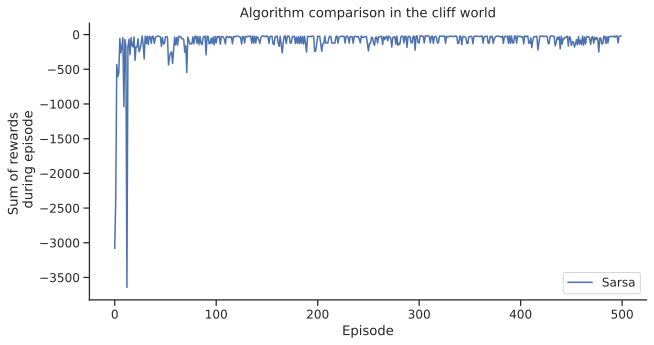

In [95]:
plt.title('Algorithm comparison in the cliff world')
#plt.plot(rewards_q_learning, 'r', label='Q-learning')
plt.plot(rewards_sarsa, 'b', label='Sarsa')
plt.xlabel('Episode')
plt.ylabel('Sum of rewards \n during episode')
plt.legend()
sns.despine()

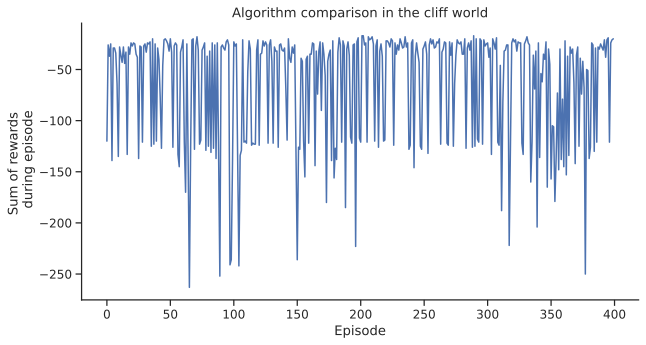

In [99]:
plt.title('Algorithm comparison in the cliff world')
#plt.plot(rewards_q_learning, 'r', label='Q-learning')
plt.plot(rewards_sarsa[100:], 'b', label='Sarsa')
plt.xlabel('Episode')
plt.ylabel('Sum of rewards \n during episode')
sns.despine()